In [10]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [11]:
BASIC_MOVES = [(0, 1), (1, 0), (0, -1), (-1, 0)]
KING_MOVES = BASIC_MOVES + [(1, 1), (1, -1), (-1, -1), (-1, 1)]
KING_NULL_MOVES = KING_MOVES + [(0, 0)]

In [12]:
class WindyGridworld:
    def __init__(self, rows, cols, wind_strength, start, goal, moves=BASIC_MOVES, stochastic_wind=False):
        self.rows = rows
        self.cols = cols
        self.wind_strength = wind_strength
        self.start = start
        self.goal = goal
        self.moves = moves
        self.stochastic_wind = stochastic_wind
        self._states = [(i, j) for i in range(self.rows) for j in range(self.cols)]

    def possible_actions(self, state):
        actions = [move for move in self.moves if self.is_valid_move(state, move)]
        return actions
    
    def is_valid_move(self, state, move):
        new_state = np.array(state) + np.array(move)
        return new_state[0] >= 0 and new_state[0] < self.rows and new_state[1] >= 0 and new_state[1] < self.cols
    
    def is_terminal(self, state):
        return tuple(state) == tuple(self.goal)
    
    def wind(self, state):
        wind = self.wind_strength[state[1]]
        
        if self.stochastic_wind:
            wind += np.random.choice([-1, 0, 1])
        
        return wind
    
    def states(self):
        return self._states
    
    def plot_episode(self, states, actions = None):
        y_coords, x_coords = zip(*states)

        plt.figure(figsize=(6, 6))
        plt.plot(x_coords, y_coords, marker='o', color='b', linestyle='-')

        plt.scatter(self.start[1], self.start[0], color='red', s=500, label='Start', marker='s')
        plt.scatter(self.goal[1], self.goal[0], color='purple', s=500, label='End', marker='*')

        if actions:
            for (y, x), (dy, dx) in zip(states[:-1], actions):
                plt.arrow(x, y, dx * 0.4, dy * 0.4, head_width=0.2, head_length=0.2, color='green')

        for idx, val in enumerate(self.wind_strength):
            plt.text(idx + 0.5, -0.5, str(val), ha='center', va='center', color='grey')
        
        plt.xlim(-0.5, self.cols + 0.5)
        plt.ylim(-1, self.rows + 0.5)
        
        plt.grid(True, which='both')
        plt.xticks(range(self.cols + 1))
        plt.yticks(range(self.rows + 1))
        
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title('Episode')
        plt.show()

    
    def step(self, state, action):
        wind = self.wind(state)
        state = np.array(state)
        action = np.array(action)
        next_state = state + action + np.array([wind, 0])
        next_state = np.clip(next_state, [0, 0], [self.rows - 1, self.cols - 1])
        reward = -1
        done = False
        if self.is_terminal(next_state):
            reward = 0
            done = True
        
        return tuple(next_state), reward, done

In [13]:
class Policy:
    def __init__(self, env: WindyGridworld):
        self.env = env
        
    def probabilities(self, state):
        pass
    
    def stochastic_action(self, state):
        pass
    
    def deterministic_action(self, state):
        pass

    def probability(self, state, action):
        pass
    
    def improve(self, state, optimal_action):
        pass


class EpislonGreedyPolicy(Policy):
    def __init__(self, env: WindyGridworld, epsilon=0.5, Q=None):
        self.env = env
        self.epislon = epsilon
        self.states = env.states()
        self.actions = {state: env.possible_actions(state) for state in self.states}

        self._probabilities = {state: {action: self.epislon/len(self.actions[state]) for action in self.actions[state]} for state in self.states}

        if Q is not None:
            self.deterministic_actions = {state: max(self.actions[state], key=lambda action: Q[state][action]) for state in self.states}
        else:
            self.deterministic_actions = {state: random.choice(self.actions[state]) for state in self.states}

        for state in self.states:
            self._probabilities[state][self.deterministic_actions[state]] += 1 - self.epislon


    def probabilities(self, state):
        return self._probabilities[state]
    
    def stochastic_action(self, state):
        return random.choices(self.actions[state], weights=[self._probabilities[state][action] for action in self.actions[state]])[0]
    
    def deterministic_action(self, state):
        return self.deterministic_actions[state]
    
    def probability(self, state, action):
        return self._probabilities[state][action]
    
    def improve(self, state, action, Q):
        optimal_action = max(self.actions[state], key=lambda action: Q[state][action])
        self.deterministic_actions[state] = optimal_action
        self._probabilities[state] = {action: self.epislon/len(self.actions[state]) for action in self.actions[state]}
        self._probabilities[state][optimal_action] += 1 - self.epislon


In [14]:
def sarsa(env, episodes = 1000, alpha = 0.5, gamma = 1, epsilon = 0.1):
    Q = {state: {action: 0 for action in env.possible_actions(state)} for state in env.states()}
    policy = EpislonGreedyPolicy(env, epsilon=epsilon, Q=Q)

    for _ in range(episodes):
        state = env.start
        action = policy.stochastic_action(state)
        while not env.is_terminal(state):
            next_state, reward, done = env.step(state, action)
            next_action = policy.stochastic_action(next_state)
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
            policy.improve(state, action, Q)
            state = next_state
            action = next_action

    return Q, policy

In [15]:
def plot_episode(env, policy, stochastic_actions = False, max_steps = 1000):
    state = env.start
    states = [state]
    actions = []

    while not env.is_terminal(state):
        if stochastic_actions:
            action = policy.stochastic_action(state)
        else:
            action = policy.deterministic_action(state)
        
        next_state, _, _ = env.step(state, action)
        states.append(next_state)
        actions.append(action)
        state = next_state

        if len(states) > max_steps:
            break
        
    env.plot_episode(states, actions)

### Exercise 6.9

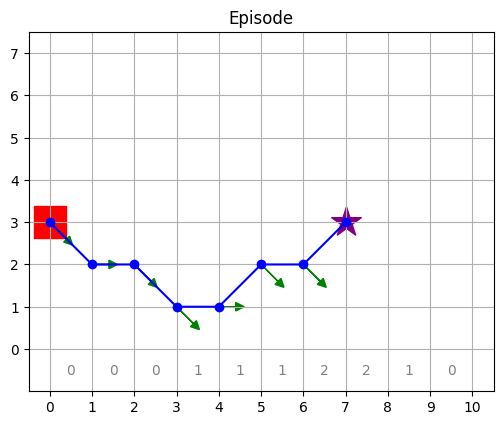

In [16]:
env = WindyGridworld(
    7,
    10,
    [0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
    (3, 0),
    (3, 7),
    moves=KING_MOVES,
    stochastic_wind=False,
)

Q, policy = sarsa(env, episodes=1000, alpha=0.5, gamma=1, epsilon=0.1)

plot_episode(env, policy, stochastic_actions=False)

### Exercise 6.10

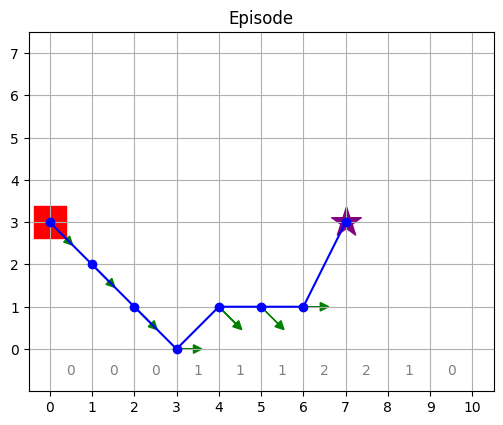

In [17]:
env = WindyGridworld(
    7,
    10,
    [0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
    (3, 0),
    (3, 7),
    moves=KING_NULL_MOVES,
    stochastic_wind=False,
)

Q, policy = sarsa(env, episodes=10000, alpha=0.1, gamma=1, epsilon=0.2)

plot_episode(env, policy, stochastic_actions=False)